In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [99]:
pip install pandas --upgrade

Note: you may need to restart the kernel to use updated packages.


## Data Preprocessing

Combining all files into a single dataframe

In [48]:
trip_data = pd.DataFrame()

In [4]:
stations_df = pd.read_csv('Divvy_Bicycle_Stations_-_In_Service.csv')

In [59]:
stations_df.columns

Index(['ID', 'Station Name', 'Total Docks', 'Docks in Service', 'Status',
       'Latitude', 'Longitude', 'Location'],
      dtype='object')

### Unifying Columns
The dataset was split into files and the files before the year 2020 had columns different than the data afer 2020. The function below drops unneeded columns and renames columns to create a dataset of unified columns

In [15]:
drop_columns = ['01 - Rental Details Rental ID','01 - Rental Details Bike ID',
                '01 - Rental Details Duration In Seconds Uncapped',
                'User Type', 'Member Gender',
                '05 - Member Details Member Birthday Year', 'trip_id', 'bikeid', 'tripduration',
                'usertype', 'gender', 'birthyear', 'member_casual', 'ride_id']

In [13]:
def manage_columns(f):
    global drop_columns
    d = pd.read_csv(f)
    if 'from_station_id' in d.columns:
        d.rename(columns={"from_station_id":"start_station_id", "to_station_id":"end_station_id", 
                      "from_station_name":"start_station_name", "to_station_name":"end_station_name"}, inplace=True)
    if "03 - Rental Start Station ID" in d.columns:
        d.rename(columns={"03 - Rental Start Station ID":"start_station_id", "02 - Rental End Station ID":"end_station_id", 
                      "03 - Rental Start Station Name":"start_station_name", "02 - Rental End Station Name":"end_station_name", 
                    "01 - Rental Details Local Start Time":"start_time", "01 - Rental Details Local End Time":"end_time"}, inplace=True)
    if "started_at" in d.columns:
        d.rename(columns={"started_at":"start_time", "ended_at":"end_time"}, inplace=True)
    d = d.drop(drop_columns, axis=1, errors='ignore')
#     print("Current dataset ", f)
#     print(d.columns)
    return d

### Imputing missing values
The function below fills in missing station name values using the coordinate information given in the dataset to find the nearest station using the Divvy Stations Dataset taking from Chicago Data Portal.

In [456]:
%%time
def prepare_dataset(f):
    
    global trip_data    
    df = manage_columns(f)
    
    if not 'start_lat' in df.columns:
        df = df.dropna(subset=['start_station_name', 'end_station_name'])
        return df
    
    empty_idx = []
    start_empty_idx = []
    end_empty_idx = []
    
    for i in range(len(df)):
        if pd.isna(df.iloc[i,3]) and pd.isna(df.iloc[i,5]) and pd.isna(df.iloc[i,7]) and pd.isna(df.iloc[i,8]) and pd.isna(df.iloc[i,9]) and pd.isna(df.iloc[i,10]):
            empty_idx.append(i)
            
        if pd.isna(df.iloc[i,3]) and not pd.isna(df.iloc[i,7]) and not pd.isna(df.iloc[i,8]):
            start_empty_idx.append(i)
        
        if pd.isna(df.iloc[i,5]) and not pd.isna(df.iloc[i,9]) and not pd.isna(df.iloc[i,10]):
            end_empty_idx.append(i)
    df = df.drop(empty_idx)

    for idx in start_empty_idx:        
        min_dist = np.inf
        station_index = 0
        for i in range(len(stations_df)):
            dist = (stations_df.iloc[i,5] - df.iloc[idx,7])**2 + (stations_df.iloc[i,6] - df.iloc[idx,8])**2
            if dist < min_dist:
                min_dist = dist
                station_index = i
        df.iloc[idx,3] = stations_df.iloc[station_index,1]
            
    for idx in end_empty_idx:
        min_dist = np.inf
        station_index = 0
        for i in range(len(stations_df)):
            dist = (stations_df.iloc[i,5] - df.iloc[idx,9])**2 + (stations_df.iloc[i,6] - df.iloc[idx,10])**2
            if dist < min_dist:
                min_dist = dist
                station_index = i
        df.iloc[idx,5] = stations_df.iloc[station_index,1]
    
    print("------------------------- df shape ", df.shape, " -------------------------")
    
    return df

Wall time: 1 ms


Below it can be seen the amount of time taken to preprocess few of the dataset files. The amount of time taken to preprocess the entirety of the dataset is around 7 days.

In [495]:
%%time
d_test = prepare_dataset('trip-data/202208-divvy-tripdata.csv')
d_test.isna().sum()

------------------------- Preprocessing dataset  trip-data/202208-divvy-tripdata.csv  -------------------------
------------------------- df shape  (785932, 11)  -------------------------
Wall time: 8h 46min 26s


rideable_type              0
start_time                 0
end_time                   0
start_station_name         0
start_station_id      112037
end_station_name         843
end_station_id        120522
start_lat                  0
start_lng                  0
end_lat                  843
end_lng                  843
dtype: int64

In [412]:
d_test = d_test.dropna()
d_test.isna().sum()

rideable_type         0
start_time            0
end_time              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
dtype: int64

In [497]:
new_trip_test = new_trip_test.append(d_test)
# new_trip_test = d_test
print(new_trip_test.shape)
new_trip_test.to_csv('trip-data-processed-new.csv', index=False)

(11842540, 11)


In [503]:
%%time
d_test = prepare_dataset('trip-data/202207-divvy-tripdata.csv')
d_test.isna().sum()

------------------------- Preprocessing dataset  trip-data/202207-divvy-tripdata.csv  -------------------------
------------------------- df shape  (823488, 11)  -------------------------
Wall time: 8h 45min 25s


rideable_type              0
start_time                 0
end_time                   0
start_station_name         0
start_station_id      112031
end_station_name         947
end_station_id        120951
start_lat                  0
start_lng                  0
end_lat                  947
end_lng                  947
dtype: int64

In [505]:
new_trip_test = new_trip_test.append(d_test)
print(new_trip_test.shape)
new_trip_test.to_csv('trip-data-processed-new.csv', index=False)

(12666028, 11)


In [3]:
new_trip_test = pd.read_csv('trip-data-processed-new.csv')
new_trip_test.shape

D:\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (2,4,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(12666028, 11)

In [40]:
new_trip_test = new_trip_test.append(df)
new_trip_test.shape

(14677608, 11)

## EDA

In [4]:
test_trip = new_trip_test.copy()

In [6]:
test_trip.shape

(14677608, 12)

In [6]:
test_trip['start_year'] = test_trip['start_time'].apply(lambda x : x[:4])

In [8]:
test_trip['start_year'].value_counts()

2022    3888152
2019    3818004
2018    3603082
2020    2760852
2021     607518
Name: start_year, dtype: int64

In [10]:
test_trip_start_station_year = test_trip[['start_year', 'start_station_name']]
test_trip_start_station_year.head()

,start_year,start_station_name
0,2018,Damen Ave & Pierce Ave
1,2018,Winthrop Ave & Lawrence Ave
2,2018,LaSalle St & Washington St
3,2018,Rush St & Hubbard St
4,2018,Blue Island Ave & 18th St


In [57]:
start_station_use_by_year_frame = start_station_use_by_year.to_frame()
start_station_use_by_year_frame.columns = [*start_station_use_by_year_frame.columns[:-1], 'count']
start_station_use_by_year_frame = start_station_use_by_year_frame.reset_index()
start_station_use_by_year_frame_sorted = start_station_use_by_year_frame.sort_values(by='count',ascending=False)
start_station_use_by_year_frame_sorted

,start_year,start_station_name,count
1183,2019,Streeter Dr & Grand Ave,67983
547,2018,Streeter Dr & Grand Ave,66944
4641,2022,Streeter Dr & Grand Ave,63249
83,2018,Canal St & Adams St,62654
708,2019,Canal St & Adams St,54389
...,...,...,...
1764,2020,Narragansett & Wrightwood,1
3530,2022,Damen Ave & 84th St,1
3529,2022,Damen Ave & 80th St,1
3522,2022,DIVVY CASSETTE REPAIR MOBILE STATION,1


In [61]:
start_station_use_by_year_frame_sorted_2018 = start_station_use_by_year_frame_sorted[start_station_use_by_year_frame_sorted['start_year']=='2018'].head()
start_station_use_by_year_frame_sorted_2019 = start_station_use_by_year_frame_sorted[start_station_use_by_year_frame_sorted['start_year']=='2019'].head()
start_station_use_by_year_frame_sorted_2020 = start_station_use_by_year_frame_sorted[start_station_use_by_year_frame_sorted['start_year']=='2020'].head()
start_station_use_by_year_frame_sorted_2021 = start_station_use_by_year_frame_sorted[start_station_use_by_year_frame_sorted['start_year']=='2021'].head()
start_station_use_by_year_frame_sorted_2022 = start_station_use_by_year_frame_sorted[start_station_use_by_year_frame_sorted['start_year']=='2022'].head()

In [65]:
start_station_use_all_years = pd.concat([start_station_use_by_year_frame_sorted_2018, 
                                        start_station_use_by_year_frame_sorted_2019,
                                        start_station_use_by_year_frame_sorted_2020,
                                        start_station_use_by_year_frame_sorted_2021,
                                        start_station_use_by_year_frame_sorted_2022], ignore_index=True)

### Top 5 utilized stations by year

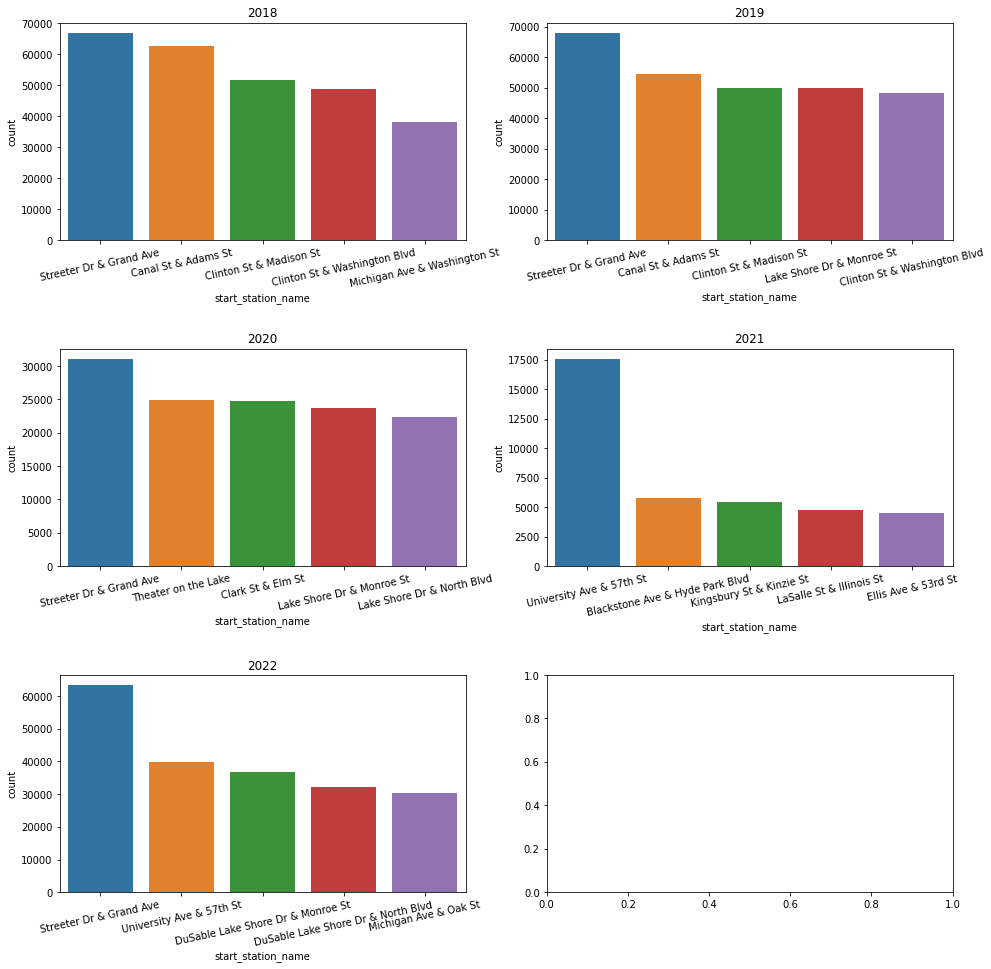

In [92]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2)
fig.set_figwidth(16)
fig.set_figheight(16)
fig.subplots_adjust(hspace=.5)
sns.barplot(data=start_station_use_by_year_frame_sorted_2018, x="start_station_name", y="count", ax=ax1).set(title="2018")
sns.barplot(data=start_station_use_by_year_frame_sorted_2019, x="start_station_name", y="count", ax=ax2).set(title="2019")
sns.barplot(data=start_station_use_by_year_frame_sorted_2020, x="start_station_name", y="count", ax=ax3).set(title="2020")
sns.barplot(data=start_station_use_by_year_frame_sorted_2021, x="start_station_name", y="count", ax=ax4).set(title="2021")
sns.barplot(data=start_station_use_by_year_frame_sorted_2022, x="start_station_name", y="count", ax=ax5).set(title="2022")
# ax1.set_xticklabels(ax1.get_xticks, rotation=45)

for tick in ax1.get_xticklabels():
    tick.set_rotation(12)

for tick in ax2.get_xticklabels():
    tick.set_rotation(12)
    
for tick in ax3.get_xticklabels():
    tick.set_rotation(12)
    
for tick in ax4.get_xticklabels():
    tick.set_rotation(12)
    
for tick in ax5.get_xticklabels():
    tick.set_rotation(12)


In [20]:
test_trip_k_means = test_trip.loc[:,['start_year', 'start_station_name', 'start_lat', 'start_lng']]
test_trip_k_means

,start_year,start_station_name,start_lat,start_lng
0,2018,Damen Ave & Pierce Ave,NaN,NaN
1,2018,Winthrop Ave & Lawrence Ave,NaN,NaN
2,2018,LaSalle St & Washington St,NaN,NaN
3,2018,Rush St & Hubbard St,NaN,NaN
4,2018,Blue Island Ave & 18th St,NaN,NaN
...,...,...,...,...
14677603,2021,Canal St & Madison St,41.882289,-87.639752
14677604,2021,Canal St & Madison St,41.882123,-87.640053
14677605,2021,Canal St & Madison St,41.881956,-87.639955
14677606,2021,Lawndale Ave & 16th St,41.860000,-87.720000


In [21]:
test_trip_k_means.dropna(inplace=True)

In [45]:
tk = test_trip_k_means.groupby(['start_station_name'])['start_station_name'].count()
tk = tk.to_frame()
tk.columns = [*tk.columns[:-1], 'count']
tk = tk.reset_index()
tk

,start_station_name,count
0,10101 S Stony Island Ave,3
1,111th St - Morgan Park Metra,12
2,2112 W Peterson Ave,1852
3,532 E 43rd St,34
4,63rd & Western Ave - north corner,13
...,...,...
1608,Yates Blvd & 75th St,1237
1609,Yates Blvd & 93rd St,120
1610,Yates Blvd & Exchange Ave,13
1611,Zapata Academy,3


In [36]:
test_trip_k_means_no_dup = test_trip_k_means.drop_duplicates(subset=['start_station_name'])
test_trip_k_means_no_dup = test_trip_k_means_no_dup.loc[:,['start_station_name', 'start_lat','start_lng']]
test_trip_k_means_no_dup

,start_station_name,start_lat,start_lng
7421086,Western Ave & Leland Ave,41.966500,-87.688400
7421087,Clark St & Montrose Ave,41.961600,-87.666000
7421088,Broadway & Belmont Ave,41.940100,-87.645500
7421089,Clark St & Randolph St,41.884600,-87.631900
7421090,Clinton St & Lake St,41.885600,-87.641800
...,...,...,...
14013667,Hamilton Park,41.760000,-87.640000
14018788,Keef Ave & South Chicago Ave,41.770000,-87.610000
14074104,DuSable Lake Shore Dr & Ohio St,41.892570,-87.614492
14080516,Halsted St & 18th St (Temp),41.858371,-87.646388


In [52]:
tk_lat_lng = pd.merge(tk, test_trip_k_means_no_dup , on='start_station_name')

In [53]:
tk_lat_lng

,start_station_name,count,start_lat,start_lng
0,10101 S Stony Island Ave,3,41.7100,-87.5800
1,111th St - Morgan Park Metra,12,41.6900,-87.6700
2,2112 W Peterson Ave,1852,41.9912,-87.6836
3,532 E 43rd St,34,41.8200,-87.6100
4,63rd & Western Ave - north corner,13,41.7800,-87.6800
...,...,...,...,...
1608,Yates Blvd & 75th St,1237,41.7588,-87.5664
1609,Yates Blvd & 93rd St,120,41.7300,-87.5700
1610,Yates Blvd & Exchange Ave,13,41.7700,-87.5700
1611,Zapata Academy,3,41.8400,-87.7300


In [65]:
quartiles = [0.25, 0.5, 0.75, 1]

for quartile in quartiles:
    print('quartile value = ', np.quantile(tk_lat_lng['count'], quartile))
    print(len(tk_lat_lng[tk_lat_lng['count'] <= np.quantile(tk_lat_lng['count'], quartile)]))

quartile value =  19.0
408
quartile value =  281.0
810
quartile value =  4179.0
1210
quartile value =  98297
1613


### Visualizing stations on a plot and coloring the points based on usage

In [116]:
def usage_row(row):
    result = ''
    if row['count'] <= 5000:
        result = 'rare'
    elif row['count'] <= 10000:
        result = 'moderate'
    elif row['count'] <= 40000:
        result = 'busy'
    elif row['count'] <= 98297:
        result = 'very busy'
    return result

In [117]:
tk_lat_lng['station_usage'] = tk_lat_lng.apply(lambda row : usage_row(row), axis=1)

In [118]:
tk_lat_lng

,start_station_name,count,start_lat,start_lng,station_usage,cluster_label
0,10101 S Stony Island Ave,3,41.7100,-87.5800,rare,8
1,111th St - Morgan Park Metra,12,41.6900,-87.6700,rare,10
2,2112 W Peterson Ave,1852,41.9912,-87.6836,rare,5
3,532 E 43rd St,34,41.8200,-87.6100,rare,2
4,63rd & Western Ave - north corner,13,41.7800,-87.6800,rare,12
...,...,...,...,...,...,...
1608,Yates Blvd & 75th St,1237,41.7588,-87.5664,rare,13
1609,Yates Blvd & 93rd St,120,41.7300,-87.5700,rare,8
1610,Yates Blvd & Exchange Ave,13,41.7700,-87.5700,rare,13
1611,Zapata Academy,3,41.8400,-87.7300,rare,7


In [119]:
from sklearn.cluster import KMeans

D:\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


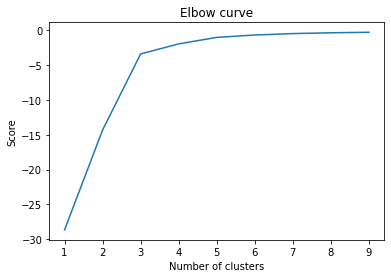

In [120]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = tk_lat_lng[['start_lat']]
X_axis = tk_lat_lng[['start_lng']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

plt.plot(K_clusters, score)
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.title('Elbow curve')
plt.show()

In [121]:
kmeans = KMeans(n_clusters=15, init='k-means++')
kmeans.fit(tk_lat_lng.loc[:, ['start_lat', 'start_lng']])

tk_lat_lng['cluster_label'] = kmeans.fit_predict(tk_lat_lng.loc[:, ['start_lat', 'start_lng']])
centers = kmeans.cluster_centers_

tk_lat_lng

,start_station_name,count,start_lat,start_lng,station_usage,cluster_label
0,10101 S Stony Island Ave,3,41.7100,-87.5800,rare,5
1,111th St - Morgan Park Metra,12,41.6900,-87.6700,rare,13
2,2112 W Peterson Ave,1852,41.9912,-87.6836,rare,3
3,532 E 43rd St,34,41.8200,-87.6100,rare,6
4,63rd & Western Ave - north corner,13,41.7800,-87.6800,rare,14
...,...,...,...,...,...,...
1608,Yates Blvd & 75th St,1237,41.7588,-87.5664,rare,7
1609,Yates Blvd & 93rd St,120,41.7300,-87.5700,rare,5
1610,Yates Blvd & Exchange Ave,13,41.7700,-87.5700,rare,7
1611,Zapata Academy,3,41.8400,-87.7300,rare,11


In [122]:
labels = kmeans.predict(tk_lat_lng.loc[:, ['start_lat', 'start_lng']])

In [123]:
tk_lat_lng['cluster_label'].value_counts()

0     200
8     146
11    142
7     129
10    129
9     125
14    115
2     106
3     105
6      97
12     95
5      78
4      73
13     72
1       1
Name: cluster_label, dtype: int64

In [125]:
tk_lat_lng_remove_1 = tk_lat_lng[tk_lat_lng['cluster_label'] != 1]
tk_lat_lng_remove_1['cluster_label'].value_counts()

0     200
8     146
11    142
7     129
10    129
9     125
14    115
2     106
3     105
6      97
12     95
5      78
4      73
13     72
Name: cluster_label, dtype: int64

<AxesSubplot:xlabel='start_lng', ylabel='start_lat'>

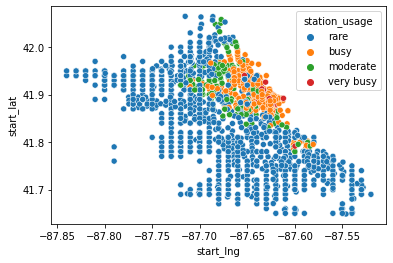

In [133]:
sns.scatterplot(data=tk_lat_lng_remove_1, x = 'start_lng', y='start_lat', hue='station_usage')

Here, it can be seen that most stations are underutilized. Hence more stations could be relocated to the areas with more demand and some stations could also be put out of commission to save costs.